In [1]:
import numpy as np
from mrashpen.models.plr_ash import PenalizedMrASH as PenMrASH
from mrashpen.models.normal_means_ash import NormalMeansASH
from mrashpen.inference.penalized_regression import PenalizedRegression as PLR

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black')

In [2]:
def center_and_scale(Z):
    dim = Z.ndim
    if dim == 1:
        Znew = Z / np.std(Z)
        Znew = Znew - np.mean(Znew)
    elif dim == 2:
        Znew = Z / np.std(Z, axis = 0)
        Znew = Znew - np.mean(Znew, axis = 0).reshape(1, -1)
    return Znew

def _ash_data(n = 200, p = 2000, p_causal = 5, pve = 0.5, k = 6): 

    def sd_from_pve (X, b, pve):
        return np.sqrt(np.var(np.dot(X, b)) * (1 - pve) / pve)
    '''
    Data from random normal distribution
    '''
    X       = np.random.normal(size = n * p).reshape(n, p)
    X       = center_and_scale(X)
    bidx    = np.random.choice(p, p_causal, replace = False)
    b       = np.zeros(p)
    b[bidx] = np.random.normal(size = p_causal)
    sigma   = sd_from_pve(X, b, pve)
    y       = np.dot(X, b) + sigma * np.random.normal(size = n)
    ''' 
    ASH prior
    '''
    wk = np.zeros(k)
    wk[1:(k-1)] = np.repeat(1/(k-1), (k - 2)) 
    wk[k-1] = 1 - np.sum(wk)
    sk = np.arange(k) * 0.2
    '''
    Note that the ash prior is not optimum
    '''
    return X, y, b, sigma, wk, sk

In [3]:
n = 2000
p = 200
X, y, b, s, wk, sk = _ash_data(n = n, p = p)
s2true = s * s
dj = np.sum(np.square(X), axis = 0)

In [4]:
plr_lbfgs = PLR(method = 'L-BFGS-B', optimize_w = True, optimize_s = False, debug = False)
plr_lbfgs.fit(X, y, sk, binit = b, winit = wk, s2init = s2true)

In [5]:
plr_lbfgs.prior

array([9.71779521e-01, 1.22108132e-05, 0.00000000e+00, 0.00000000e+00,
       9.03246721e-03, 1.91758012e-02])

In [6]:
wkopt = plr_lbfgs.prior

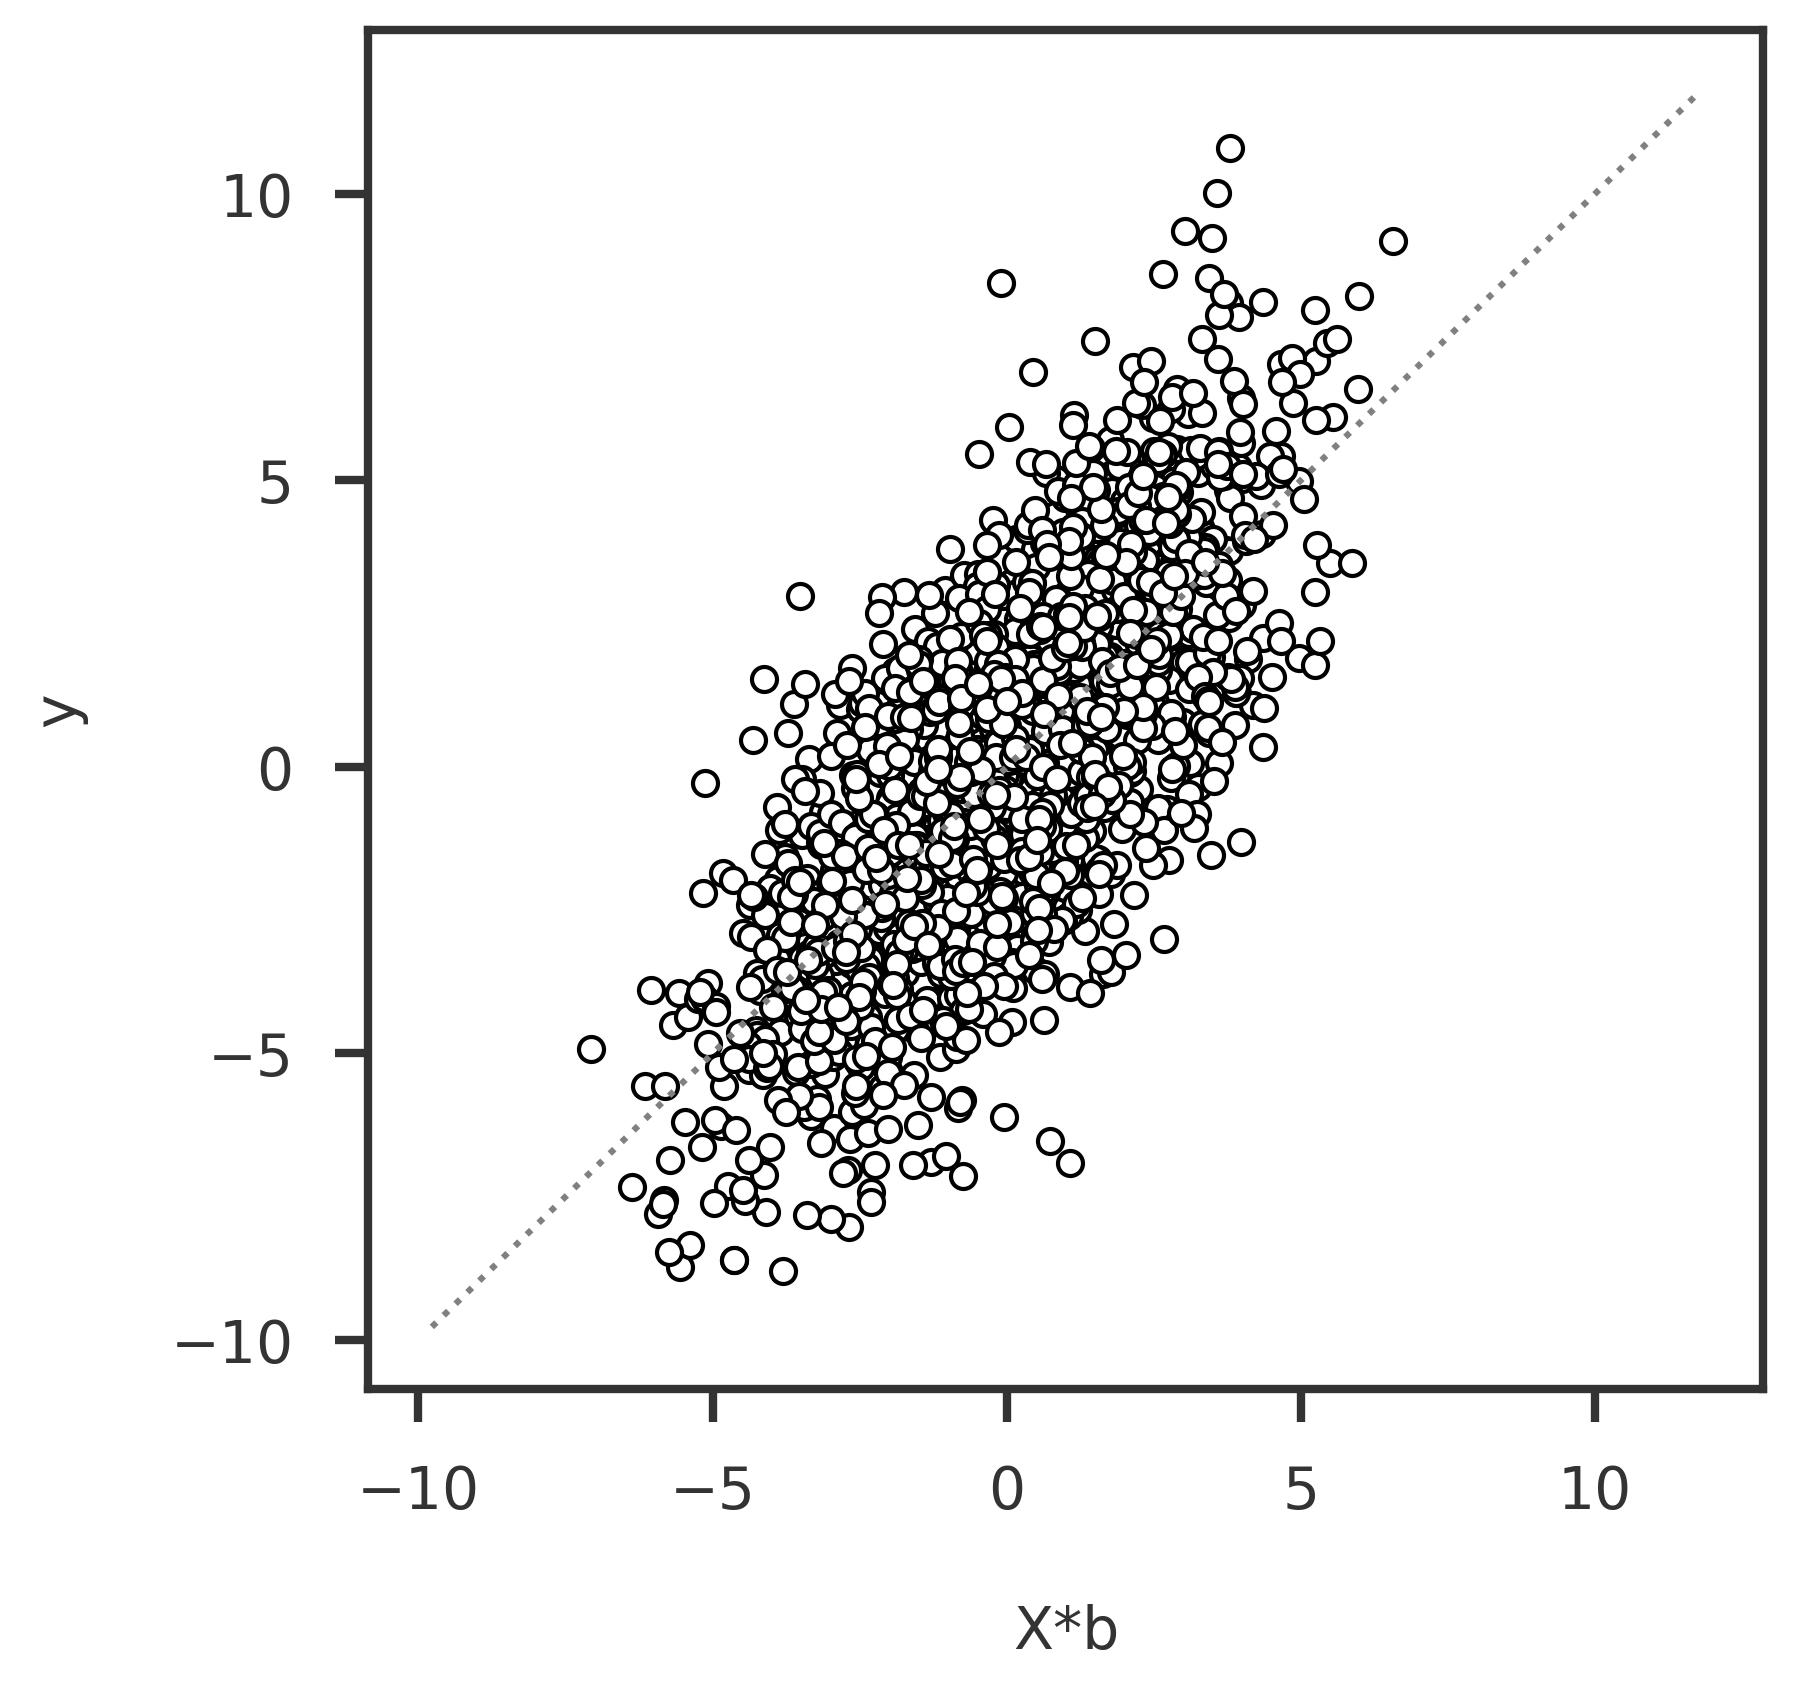

In [7]:
fig = plt.figure(figsize = (6, 6))
ax1 = fig.add_subplot(111)
ax1.scatter(np.dot(X, b), y, edgecolor = 'black', facecolor='white', label="ytest")
ax1.set_xlabel("X*b")
ax1.set_ylabel("y")
mpl_utils.plot_diag(ax1)
plt.show()

In [8]:
sigma2seq = np.logspace(-1, 2, 50)

In [9]:
sigma2seq[-1]

100.0

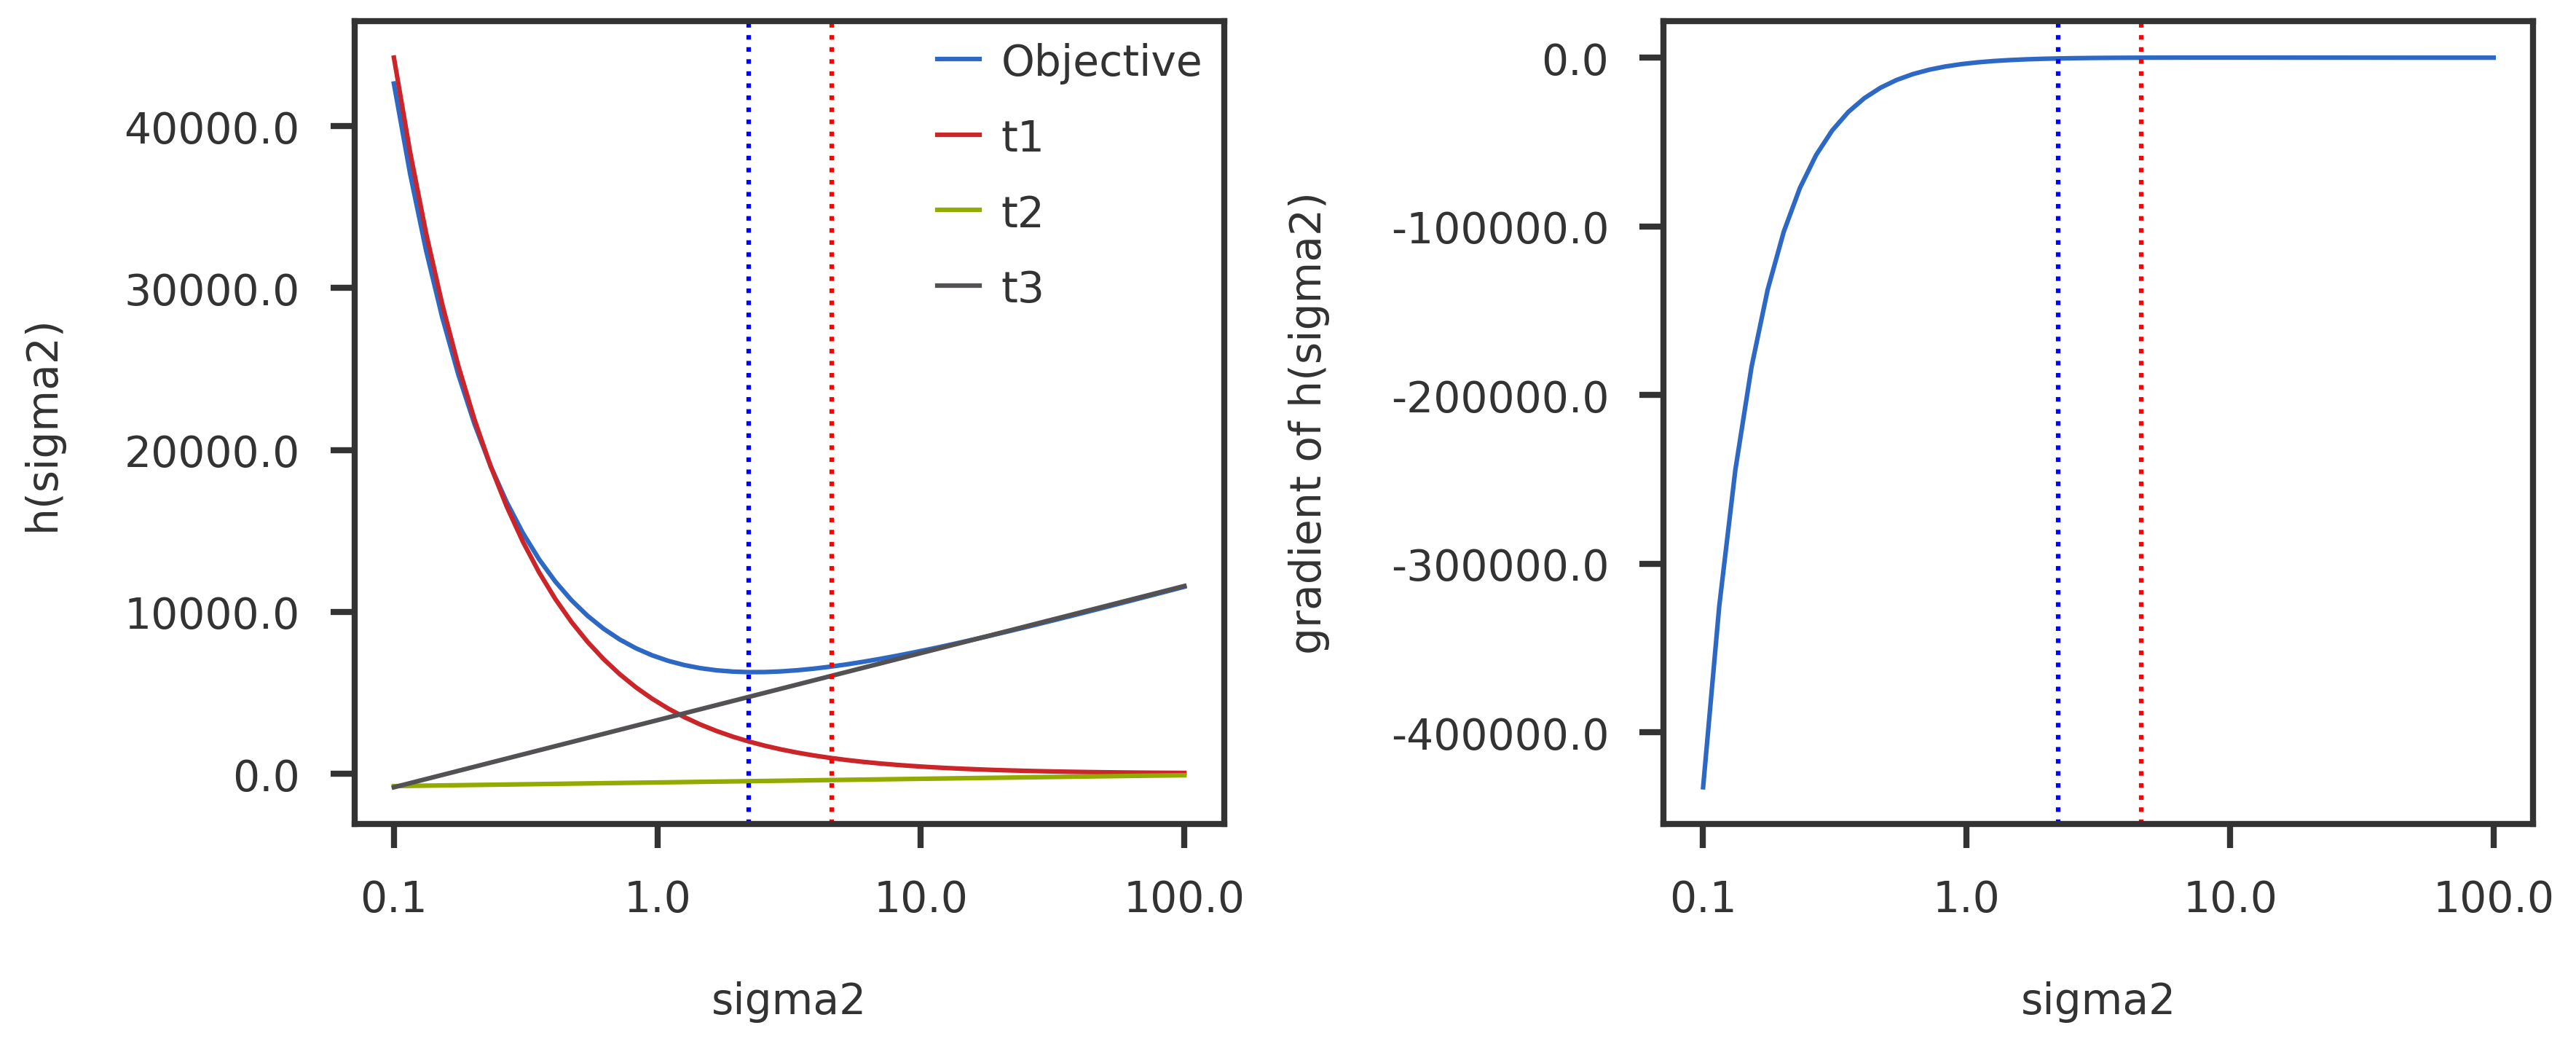

In [26]:
objseq    = np.zeros_like(sigma2seq)
objt1seq  = np.zeros_like(sigma2seq)
objt2seq  = np.zeros_like(sigma2seq)
objt3seq  = np.zeros_like(sigma2seq)
s2gradseq = np.zeros_like(sigma2seq)
n, p = X.shape
for i, sigma2 in enumerate(sigma2seq):
    sigma = np.sqrt(sigma2)
    pmash = PenMrASH(X, y, b, sigma, wkopt, sk, dj = dj, debug = False)
    obj, t1, t2, t3 = pmash.objective_debug()
    objseq[i]    = t1 + t2 + t3
    objt1seq[i]  = t1
    objt2seq[i]  = t2
    objt3seq[i]  = t3
    s2gradseq[i] = pmash.gradients[2]

fig = plt.figure(figsize = (12, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

xscale = 'log10'
yscale = 'linear'
for xdata, xlegend in zip([objseq, objt1seq, objt2seq, objt3seq], 
                          ['Objective', 't1', 't2', 't3']):
    ax1.plot(mpl_utils.scale_array(sigma2seq, xscale), 
             mpl_utils.scale_array(xdata, yscale),
             label = xlegend
            )
ax2.plot(mpl_utils.scale_array(sigma2seq, xscale),
         mpl_utils.scale_array(s2gradseq, yscale))
# mpl_utils.set_xticks(ax1, scale = 'log10', spacing = 'log2')
for ax in [ax1, ax2]:
    mpl_utils.set_xticks(ax, scale = xscale, spacing = xscale)
    mpl_utils.set_yticks(ax, scale = yscale, spacing = yscale)
    ax.axvline(x = mpl_utils.scale_array(np.array([s2true]), xscale)[0], color = 'red', ls = 'dotted')
    ax.axvline(x = mpl_utils.scale_array(np.array([sigma2seq[np.argmin(objseq)]]), xscale)[0], 
               color = 'blue', ls = 'dotted')
    ax.set_xlabel("sigma2")
ax1.set_ylabel("h(sigma2)")
ax2.set_ylabel("gradient of h(sigma2)")
ax1.legend()
plt.tight_layout()
plt.show()

In [15]:
def M_operator(x, vj, wk, sk):
    nm = NormalMeansASH(x, vj, wk, sk)
    Mx = nm.y + nm.yvar + nm.logML_deriv
    Mx_deriv = 1 + nm.yvar * nm.logML_deriv2
    return Mx, Mx_deriv

def M_operator_inverse(y, vj, wk, sk):
    '''
    solve for M(x) = y
    using Newton-Raphson method
    '''
    x = y.copy()
    for i in range(50):
        Mx, Mx_deriv = M_operator(x, vj, wk, sk)
        x = x - (Mx - y) / Mx_deriv
    return x

def penalty_operator(b, vj, wk, sk):
    z  = M_operator_inverse(b, vj, wk, sk)
    nm = NormalMeansASH(z, vj, wk, sk)
    lj = - nm.logML - 0.5 * nm.yvar * np.square(nm.logML_deriv)
    return lj

def unscaled_hloss(X, y, b, sigma, wk, sk, dj):
    s2    = sigma * sigma
    vj    = np.sqrt(s2 / dj)
    r     = y - np.dot(X, b)
    rTr   = np.sum(np.square(r))
    rTX   = np.dot(r.T, X)
    lj    = penalty_operator(b, vj, wk, sk)
    obj   = (0.5 * rTr / s2) + np.sum(lj)
    obj  += 0.5 * (n - p) * np.log(2 * np.pi * s2)
    return obj

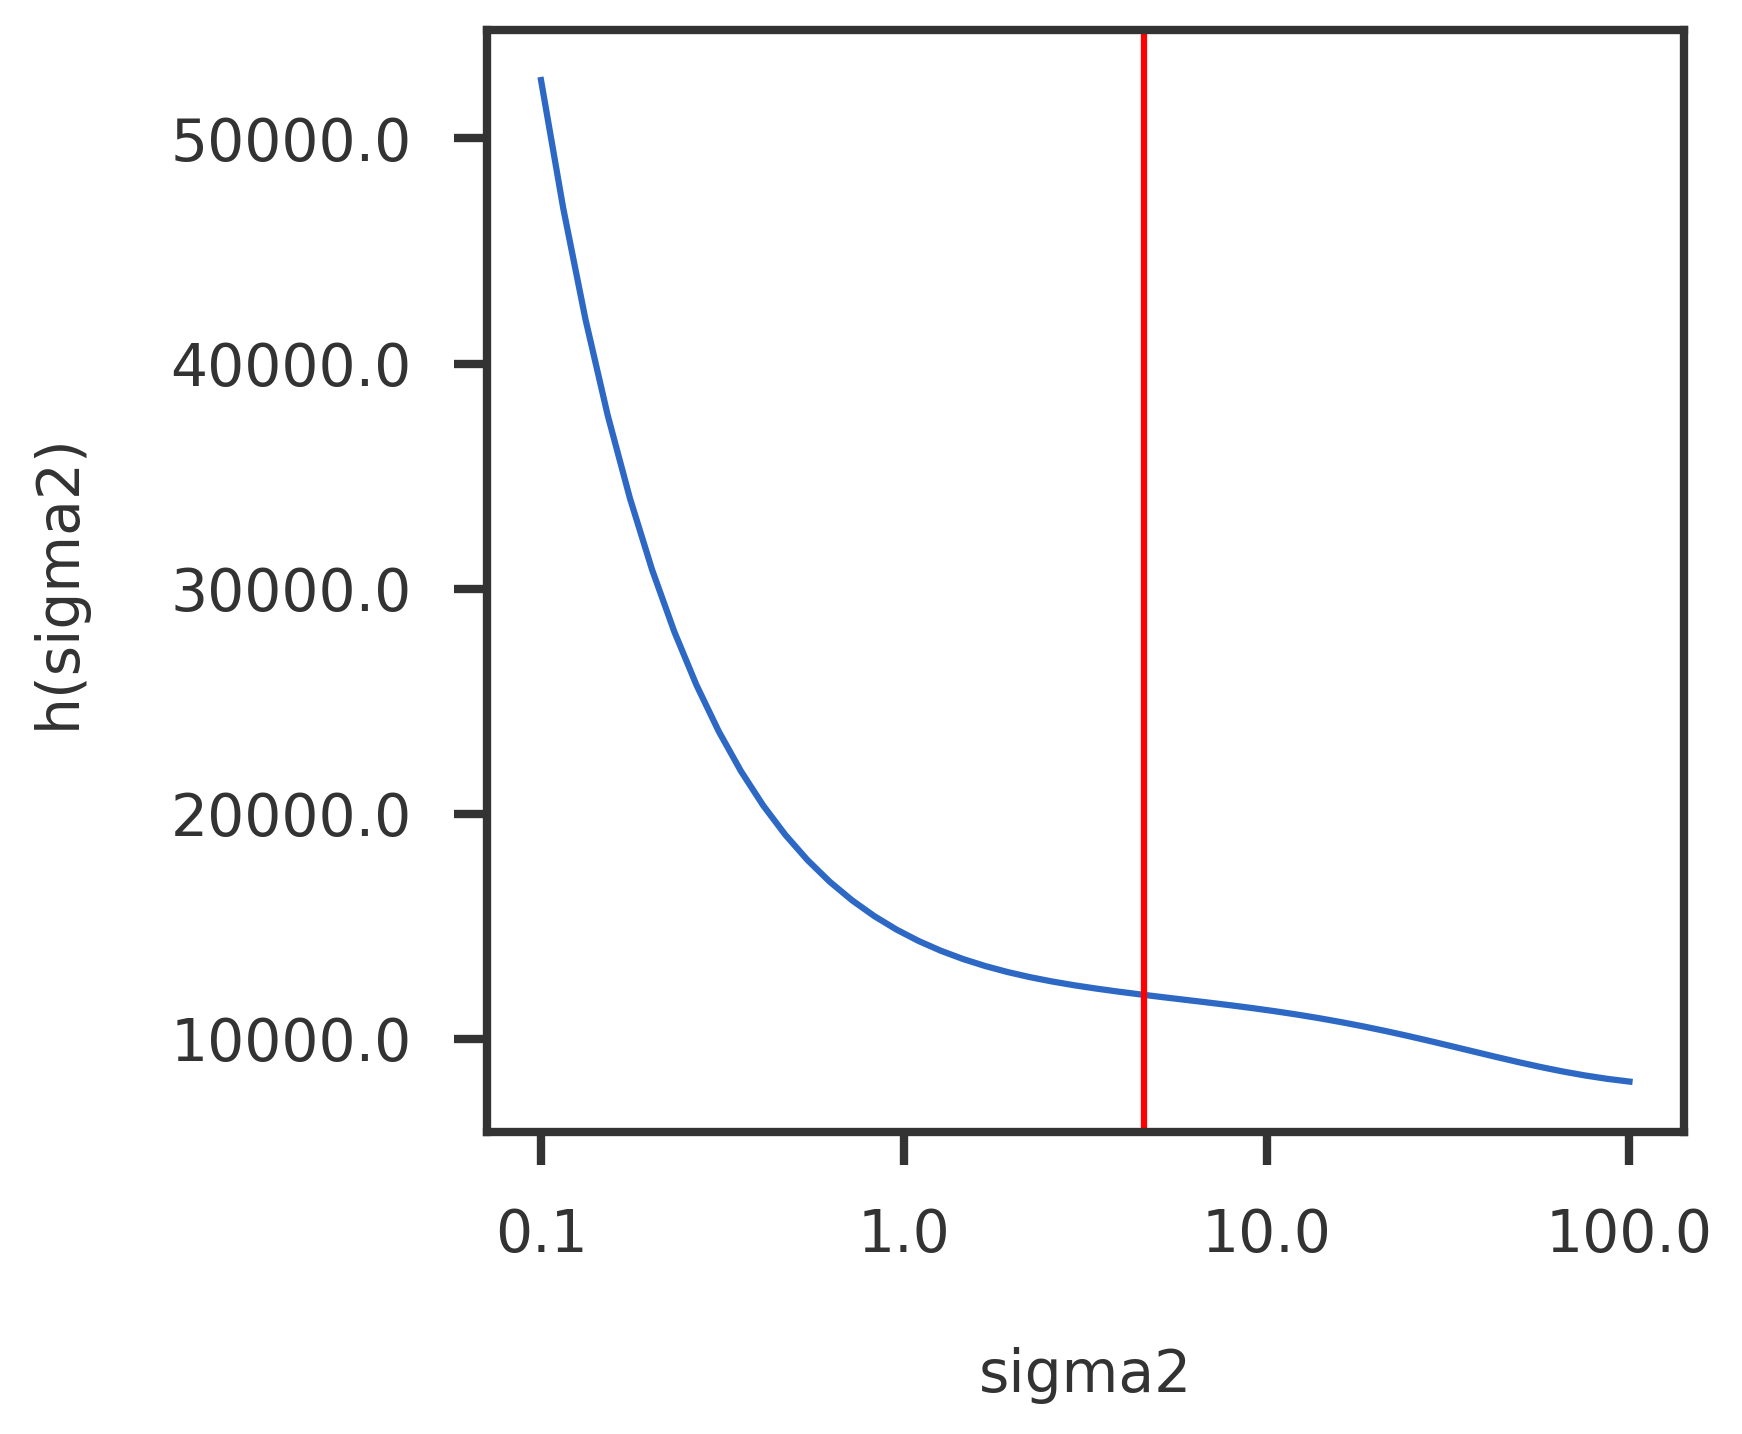

In [16]:
objseq = np.zeros_like(sigma2seq)
#s2gradseq = np.zeros_like(sigma2seq)
n, p = X.shape
for i, sigma2 in enumerate(sigma2seq):
    sigma = np.sqrt(sigma2)
    objseq[i] = unscaled_hloss(X, y, b, sigma, wk, sk, dj)
    #pmash = PenMrASH(X, y, b, sigma, wk, sk, dj = dj, debug = False)
    #objseq[i] = pmash.objective
    #s2gradseq[i] = pmash.gradients[2]

fig = plt.figure(figsize = (6, 5))
ax1 = fig.add_subplot(111)
# ax2 = fig.add_subplot(122)

xscale = 'log10'
yscale = 'linear'
ax1.plot(mpl_utils.scale_array(sigma2seq, xscale), 
         mpl_utils.scale_array(objseq, yscale))
# ax2.plot(mpl_utils.scale_array(sigma2seq, xscale),
#          mpl_utils.scale_array(s2gradseq, yscale))
# mpl_utils.set_xticks(ax1, scale = 'log10', spacing = 'log2')
for ax in [ax1]:
    mpl_utils.set_xticks(ax, scale = xscale, spacing = xscale)
    mpl_utils.set_yticks(ax, scale = yscale, spacing = yscale)
    ax.axvline(x = mpl_utils.scale_array(np.array([s2true]), xscale)[0], color = 'red')
    ax.set_xlabel("sigma2")
ax1.set_ylabel("h(sigma2)")
# ax2.set_ylabel("gradient of h(sigma2)")
plt.tight_layout()
plt.show()

In [21]:
sigma2seq[np.argmin(objseq)]

2.2229964825261943

In [22]:
s2true

4.587504322308964